## Knight Frank assessment for ESG Data Analyst
Exploratory Data Analysis for Leeds building ESG variables and price property transect

In [1]:
##########################################
#Knight Frank ESG Data Analyst Assessment#
#Maintainer: Christopher Chan            #
#Date: 2024-12-19                        #
#Version: 0.0.2                          #
##########################################

# Data ingestion

import os, sys, re
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
from pathlib import Path

# Data Paths
data_raw = Path("../data/01_raw")
data_intermediate = Path("../data/02_intermediate")

# Figure Paths
if os.path.exists("../docs/figures"):
    print("Figure dir exist")
    figure_path = Path("../docs/figures")
else:
    os.makedirs("../docs/figures")
    figure_path = Path("../docs/figures")

if os.path.exists(f"{data_intermediate}/property_data.parquet"):
    print("Cleaned parquet file exist, reading from 02_intermediate")
    prop_df = pd.read_parquet(f"{data_intermediate}/property_data.parquet", engine="pyarrow", dtype_backend="pyarrow")

else:
    with open(f"{data_raw}/Property Data -- data science test.csv", "r") as df:
        prop_df = pd.read_csv(df, index_col = 0)
        # Solve duplicates with left merge with last and first
        prop_df_dup = prop_df[prop_df.duplicated(subset = "LRUniqueID", keep = "last")]
        prop_df.drop_duplicates(subset = "LRUniqueID", keep = "first", inplace = True)
        prop_df = pd.merge(prop_df, prop_df_dup, how = "left", sort = True)
        assert not prop_df.duplicated().any(), "Duplicate rows found in DataFrame"
        
    # Data Dtype Cleaning
    propdf_dtype = {
        # Datetime
        "SaleDate": lambda x: pd.to_datetime(x, format='%d/%m/%Y').dt.strftime('%Y-%m-%d'),
        "INSPECTION_DATE": lambda x: pd.to_datetime(x, format='%d/%m/%Y').dt.strftime('%Y-%m-%d'),
        # Boolean
        "NewBuild": lambda x: x.replace({'Y': True, 'N': False, ' ': None}),
        "MAINS_GAS_FLAG": lambda x: x.replace({'Y': True, 'N': False, ' ': None}),
        # Numeric
        "SalePrice": lambda x: pd.to_numeric(x, errors='coerce'),
        "UDPRNKey": lambda x: pd.to_numeric(x, errors='coerce'),
        "TOTAL_FLOOR_AREA": lambda x: pd.to_numeric(x, errors='coerce'),
        "NUMBER_HABITABLE_ROOMS": lambda x: pd.to_numeric(x, errors='coerce'),
        "EXTENSION_COUNT": lambda x: pd.to_numeric(x, errors='coerce'),
        "CURRENT_ENERGY_EFFICIENCY": lambda x: pd.to_numeric(x, errors='coerce'),
        "ENERGY_CONSUMPTION_POTENTIAL": lambda x: pd.to_numeric(x, errors='coerce'),
        "POTENTIAL_ENERGY_EFFICIENCY": lambda x: pd.to_numeric(x, errors='coerce'),
        "ENERGY_CONSUMPTION_CURRENT": lambda x: pd.to_numeric(x, errors='coerce'),
        "ENERGY_CONSUMPTION_POTENTIAL": lambda x: pd.to_numeric(x, errors='coerce'),
        "Latitude": lambda x: pd.to_numeric(x, errors='coerce'),
        "Longitude": lambda x: pd.to_numeric(x, errors='coerce')
    }
    
    for col, dtype in propdf_dtype.items():
        if callable(dtype):
            prop_df[col] = dtype(prop_df[col])
            
    # Then convert all other columns to string
    other_cols = [col for col in prop_df.columns if col not in propdf_dtype]
    prop_df[other_cols] = prop_df[other_cols].astype("string")
    
    print(prop_df.info())
    
    print("Creating parquet file from csv, writing parquet to 02_intermediate")
    prop_df.to_parquet(f"{data_intermediate}/property_data.parquet", engine="pyarrow")
    with open(f"{data_intermediate}/property_data.parquet", "rb") as pqt:
        prop_df = pd.read_parquet(pqt, engine="pyarrow", dtype_backend="pyarrow")

# Read prop df as geodataframe and save as geojson
# Projection: EPSG:27700
if os.path.exists(f"{data_intermediate}/property.geojson"):
    print("File exist, reading from 02_intermediate")
    with open(f"{data_intermediate}/property.geojson", "r") as gdf:
        prop_gdf = gpd.read_file(gdf)

else:
    print("Creating gdf from pandas, writing geojson to 02_intermediate")
    prop_gdf = gpd.GeoDataFrame(prop_df, geometry=gpd.points_from_xy(prop_df["Longitude"], prop_df["Latitude"]), crs="EPSG:27700")
    prop_gdf.to_file(f"{data_intermediate}/property.geojson", driver="GeoJSON")

# Read rail df as geodataframe and save as geojson
# Project: EPSG:27700

with open(f"{data_raw}/UK train and metro stations.csv", "r") as df:
    rail_df = pd.read_csv(df)
    # Convert object to string
    rail_df["Station"] = rail_df["Station"].astype("string")
    rail_df_dup = rail_df[rail_df.duplicated(subset = "Station", keep = "last")]
    rail_df.drop_duplicates(subset = "Station", keep = "first", inplace = True)
    rail_df = pd.merge(rail_df, rail_df_dup, how = "left", sort = True)
    assert not rail_df.duplicated().any(), "Duplicate rows found in DataFrame"
    
if os.path.exists(f"{data_intermediate}/train_metro.geojson"):
    print("File exist, reading from 02_intermediate")
    with open(f"{data_intermediate}/train_metro.geojson") as gdf:
        rail_gdf = gpd.read_file(gdf)

else:
    print("Creating gdf from pandas, writing geojson to 02_intermediate")
    rail_gdf = gpd.GeoDataFrame(rail_df, geometry=gpd.points_from_xy(rail_df["lng"], rail_df["lat"]), crs="EPSG:27700")
    rail_gdf.to_file(f"{data_intermediate}/train_metro.geojson", driver="GeoJSON")

Cleaned parquet file exist, reading from 02_intermediate
File exist, reading from 02_intermediate
File exist, reading from 02_intermediate


In [2]:
prop_df

LRUniqueID  SalePrice    SaleDate  \
0       {0001B56C-8D8B-48A9-992E-2C511C619F98}     113500  2005-01-27   
1       {0001CB91-6591-4C80-BE58-E7991CA27D10}     280000  2007-05-09   
2       {0001DD27-1EDE-4C5F-AE99-AF5A75776E41}     105000  2009-09-23   
3       {0002C0DB-538D-41CD-B3A7-B95494334ED0}     135000  2011-04-06   
4       {0002DA7B-BD24-4C13-845F-C4AF94A6F592}     169000  2009-07-07   
...                                        ...        ...         ...   
151280  {FFFCA884-5EF9-495E-8FB1-7189391D389E}     232500  2010-06-15   
151281  {FFFD3ED0-B626-4B4B-AF0A-19955A9479CA}     135000  2006-01-03   
151282  {FFFD98AD-75A0-4564-93D8-C874D6EB93B8}     250000  2014-08-22   
151283  {FFFE1CD9-F1B9-48BF-B264-294806ACB7E1}     176000  2006-01-27   
151284  {FFFEB677-BFB7-4BD9-83AD-E1022F09A0C8}     110000  2014-08-15   

          PCUnit   PropertyType NewBuild     Tenure             Add1  \
0       LS28 5TX       Terraced    False   Freehold                5   
1       LS6 1LD        Terraced    False   Freehold               82   
2       LS12 3TZ       Terraced    False   Freehold              128   
3       WF3 3LF        Detached    False   Freehold                3   
4       LS6 1BJ            Flat    False  Leasehold               8A   
...          ...            ...      ...        ...              ...   
151280  LS19 6HX  Semi-Detached    False   Freehold                5   
151281  LS21 1BU       Terraced    False   Freehold               15   
151282  LS22 6SN       Detached    False   Freehold               18   
151283  LS18 5NQ           Flat     True  Leasehold  BRIDGE PLACE, 1   
151284  LS26 9BZ  Semi-Detached    False   Freehold               46   

                Add2                  Add3  ... CURRENT_ENERGY_EFFICIENCY  \
0                           NEW PARK PLACE  ...                        39   
1                           HAROLD TERRACE  ...                         1   
2                              PUDSEY ROAD  ...                        13   
3                          GREENMOOR CLOSE  ...                        51   
4                        HYDE PARK TERRACE  ...                        38   
...              ...                   ...  ...                       ...   
151280                           PARK ROAD  ...                        38   
151281                       CRAVEN STREET  ...                        67   
151282                HALL ORCHARDS AVENUE  ...                        58   
151283  APARTMENT 12             TROY ROAD  ...                        77   
151284                       EMBLETON ROAD  ...                        64   

       POTENTIAL_ENERGY_EFFICIENCY ENERGY_CONSUMPTION_CURRENT  \
0                               42                        389   
1                                1                        720   
2                               39                        547   
3                               70                        394   
4                               45                        425   
...                            ...                        ...   
151280                          46                        457   
151281                          68                        217   
151282                          72                        275   
151283                          85                        212   
151284                          73                        226   

       ENERGY_CONSUMPTION_POTENTIAL  MAINS_GAS_FLAG     BUILT_FORM  \
0                             367.0            True    Mid-Terrace   
1                             720.0            True    Mid-Terrace   
2                             330.0            True    End-Terrace   
3                             237.0            True  Semi-Detached   
4                             367.0            True    End-Terrace   
...                             ...             ...            ...   
151280                        388.0            True    End-Terrace   
151281                      

In [3]:
prop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151285 entries, 0 to 151284
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype          
---  ------                        --------------   -----          
 0   LRUniqueID                    151285 non-null  string[pyarrow]
 1   SalePrice                     151285 non-null  int64[pyarrow] 
 2   SaleDate                      151285 non-null  string[pyarrow]
 3   PCUnit                        151285 non-null  string[pyarrow]
 4   PropertyType                  151285 non-null  string[pyarrow]
 5   NewBuild                      151285 non-null  bool[pyarrow]  
 6   Tenure                        151285 non-null  string[pyarrow]
 7   Add1                          151285 non-null  string[pyarrow]
 8   Add2                          151285 non-null  string[pyarrow]
 9   Add3                          151285 non-null  string[pyarrow]
 10  Add4                          151285 non-null  string[pyarrow]
 11  

In [4]:
prop_gdf

LRUniqueID  SalePrice   SaleDate  \
0       {0001B56C-8D8B-48A9-992E-2C511C619F98}     113500 2005-01-27   
1       {0001CB91-6591-4C80-BE58-E7991CA27D10}     280000 2007-05-09   
2       {0001DD27-1EDE-4C5F-AE99-AF5A75776E41}     105000 2009-09-23   
3       {0002C0DB-538D-41CD-B3A7-B95494334ED0}     135000 2011-04-06   
4       {0002DA7B-BD24-4C13-845F-C4AF94A6F592}     169000 2009-07-07   
...                                        ...        ...        ...   
151280  {FFFCA884-5EF9-495E-8FB1-7189391D389E}     232500 2010-06-15   
151281  {FFFD3ED0-B626-4B4B-AF0A-19955A9479CA}     135000 2006-01-03   
151282  {FFFD98AD-75A0-4564-93D8-C874D6EB93B8}     250000 2014-08-22   
151283  {FFFE1CD9-F1B9-48BF-B264-294806ACB7E1}     176000 2006-01-27   
151284  {FFFEB677-BFB7-4BD9-83AD-E1022F09A0C8}     110000 2014-08-15   

          PCUnit   PropertyType  NewBuild     Tenure             Add1  \
0       LS28 5TX       Terraced     False   Freehold                5   
1       LS6 1LD        Terraced     False   Freehold               82   
2       LS12 3TZ       Terraced     False   Freehold              128   
3       WF3 3LF        Detached     False   Freehold                3   
4       LS6 1BJ            Flat     False  Leasehold               8A   
...          ...            ...       ...        ...              ...   
151280  LS19 6HX  Semi-Detached     False   Freehold                5   
151281  LS21 1BU       Terraced     False   Freehold               15   
151282  LS22 6SN       Detached     False   Freehold               18   
151283  LS18 5NQ           Flat      True  Leasehold  BRIDGE PLACE, 1   
151284  LS26 9BZ  Semi-Detached     False   Freehold               46   

                Add2                  Add3  ... POTENTIAL_ENERGY_EFFICIENCY  \
0                           NEW PARK PLACE  ...                          42   
1                           HAROLD TERRACE  ...                           1   
2                              PUDSEY ROAD  ...                          39   
3                          GREENMOOR CLOSE  ...                          70   
4                        HYDE PARK TERRACE  ...                          45   
...              ...                   ...  ...                         ...   
151280                           PARK ROAD  ...                          46   
151281                       CRAVEN STREET  ...                          68   
151282                HALL ORCHARDS AVENUE  ...                          72   
151283  APARTMENT 12             TROY ROAD  ...                          85   
151284                       EMBLETON ROAD  ...                          73   

       ENERGY_CONSUMPTION_CURRENT ENERGY_CONSUMPTION_POTENTIAL MAINS_GAS_FLAG  \
0                             389                        367.0           True   
1                             720                        720.0           True   
2                             547                        330.0           True   
3                             394                        237.0           True   
4                             425                        367.0           True   
...                           ...                          ...            ...   
151280                        457                        388.0           True   
151281                        217                        209.0           True   
151282                        275                        201.0           True   
151283                        212                        207.0          False   
151284                        226                        161.0           True   

           BUILT_FORM         CONSTRUCTION_AGE_BAND      LMK_KEY  Latitude  \
0         Mid-Terrace  England and Wales: 1976-1982  2.72584E+32 -1.662515   
1         Mid-Terrace  England and Wales: 1900-1929  8.85704E+31 -1.574113   
2         End-Terrace  England and Wales: 1950-1966  2.64212E+32 -1.617543   
3       Semi-Detached  England and Wales: 1950-1966  4.54813

In [5]:
prop_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 151285 entries, 0 to 151284
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   LRUniqueID                    151285 non-null  object        
 1   SalePrice                     151285 non-null  int32         
 2   SaleDate                      151285 non-null  datetime64[ms]
 3   PCUnit                        151285 non-null  object        
 4   PropertyType                  151285 non-null  object        
 5   NewBuild                      151285 non-null  bool          
 6   Tenure                        151285 non-null  object        
 7   Add1                          151285 non-null  object        
 8   Add2                          151285 non-null  object        
 9   Add3                          151285 non-null  object        
 10  Add4                          151285 non-null  object        
 11  Add5 

In [6]:
rail_gdf

Station       x       y        lat       lng  \
0               Abbey Road DLR Station  539082  183349  51.531926  0.003737   
1                           Abbey Wood  547372  179055        NaN       NaN   
2     Abbey Wood (London) Rail Station  547374  179035  51.491062  0.121394   
3                    Aber Rail Station  314870  186950  51.574966 -3.229828   
4         Abercynon North Rail Station  308292  194891  51.645313 -3.326803   
...                                ...     ...     ...        ...       ...   
3616      York Place (Edinburgh Trams)  325888  674363  55.956550 -3.188547   
3617                 York Rail Station  459600  451700  53.957966 -1.093182   
3618               Yorton Rail Station  350454  323744  52.808957 -2.736461   
3619        Ystrad Mynach Rail Station  314200  194300  51.640934 -3.241295   
3620       Ystrad Rhondda Rail Station  298610  194890  51.643640 -3.466685   

                   geometry  
0      POINT (0.004 51.532)  
1                      None  
2        POINT (0.1 51.491)  
3      POINT (-3.23 51.575)  
4     POINT (-3.327 51.645)  
...                     ...  
3616  POINT (-3.189 55.957)  
3617  POINT (-1.093 53.958)  
3618  POINT (-2.736 52.809)  
3619  POINT (-3.241 51.641)  
3620  POINT (-3.467 51.644)  

[3621 rows x 6 columns]

In [7]:
rail_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3621 entries, 0 to 3620
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Station   3621 non-null   object  
 1   x         3621 non-null   int32   
 2   y         3621 non-null   int32   
 3   lat       3610 non-null   float64 
 4   lng       3610 non-null   float64 
 5   geometry  3610 non-null   geometry
dtypes: float64(2), geometry(1), int32(2), object(1)
memory usage: 141.6+ KB


In [8]:
# Create OSM base map with Leeds in the centre
f = folium.Figure(width=1000, height=750)
map = folium.Map(location=[53.80127731220501, -1.5506368871616953],
                 #width=750,
                 #height=500,
                 tiles="OpenStreetMap",
                 zoom_start=10,
                 crs="EPSG3857",
                 control_scale=True,
                 zoom_on_click=True).add_to(f)

# Add geometry using x and y cus folium does not read EPSG:27700, retain for geoanalysis
# Isolate visualisation dataset without NA

# The null type seem to all be London Stations
railGDF_woNA = rail_gdf.dropna(how = "any")
assert railGDF_woNA.isna().any().all() == False, "NaN not removed for station geodataframe!"

station_group = folium.FeatureGroup(name="Stations")

for idx, i in railGDF_woNA.iterrows():
    folium.Marker(
        location = [i.geometry.y, i.geometry.x],
        popup = f"Station: {i['Station']}",
        icon = folium.Icon(color="red", icon="train", prefix='fa')
    ).add_to(station_group)

# Add property geodata, coloured by PropertyType
#propGDF_woNA = prop_gdf.dropna(subset = ["Longitude", "Latitude"], how = "any")
#assert propGDF_woNA.isna().any().all() == False, "NaN not removed for property geodataframe!"
#
#proptype_cdict = {
#    "Flat": "red",
#    "Terraced": "green",
#    "Semi-Detached": "blue",
#    "Detached": "purple"
#}
#
#property_group = folium.FeatureGroup(name="Properties")
#
#for idx, i in propGDF_woNA.iterrows():
#    folium.Marker(
#        location = [i.geometry.y, i.geometry.x],
#        popup = f"Unique ID: {i['LRUniqueID']}\
#                  Property Type: {i['PropertyType']}",
#        icon = folium.Icon(color=proptype_cdict[i['PropertyType']], icon="house", prefix="fa")
#    ).add_to(property_group)

# Add the feature group to the map
# Property group seems to take too long to display
station_group.add_to(map)
#property_group.add_to(map)

map

EPSG:3857


/opt/homebrew/Caskroom/miniforge/base/envs/ds_knight_frank/lib/python3.10/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


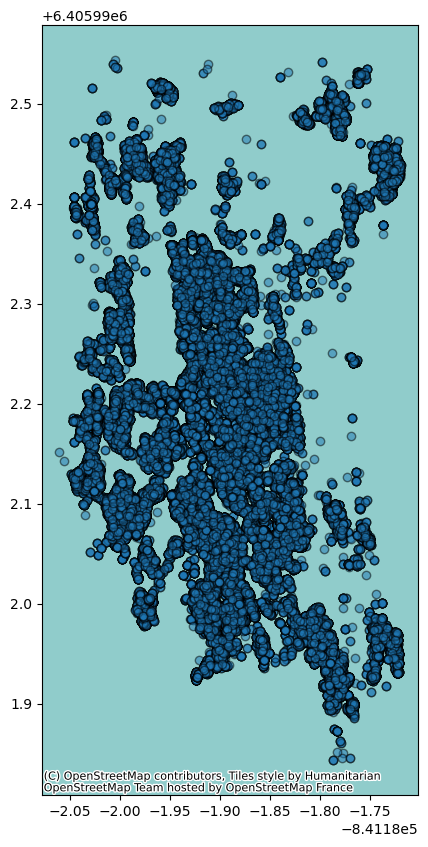

In [9]:
propgdf_3857 = prop_gdf.to_crs(epsg=3857)

print(propgdf_3857.crs)

ax = propgdf_3857.plot(figsize = (10, 10), alpha = 0.5, edgecolor = "k")
cx.add_basemap(ax = ax)

## Non-geospatial descriptive statistics exploration for Leeds property

In [10]:
prop_df

LRUniqueID  SalePrice    SaleDate  \
0       {0001B56C-8D8B-48A9-992E-2C511C619F98}     113500  2005-01-27   
1       {0001CB91-6591-4C80-BE58-E7991CA27D10}     280000  2007-05-09   
2       {0001DD27-1EDE-4C5F-AE99-AF5A75776E41}     105000  2009-09-23   
3       {0002C0DB-538D-41CD-B3A7-B95494334ED0}     135000  2011-04-06   
4       {0002DA7B-BD24-4C13-845F-C4AF94A6F592}     169000  2009-07-07   
...                                        ...        ...         ...   
151280  {FFFCA884-5EF9-495E-8FB1-7189391D389E}     232500  2010-06-15   
151281  {FFFD3ED0-B626-4B4B-AF0A-19955A9479CA}     135000  2006-01-03   
151282  {FFFD98AD-75A0-4564-93D8-C874D6EB93B8}     250000  2014-08-22   
151283  {FFFE1CD9-F1B9-48BF-B264-294806ACB7E1}     176000  2006-01-27   
151284  {FFFEB677-BFB7-4BD9-83AD-E1022F09A0C8}     110000  2014-08-15   

          PCUnit   PropertyType NewBuild     Tenure             Add1  \
0       LS28 5TX       Terraced    False   Freehold                5   
1       LS6 1LD        Terraced    False   Freehold               82   
2       LS12 3TZ       Terraced    False   Freehold              128   
3       WF3 3LF        Detached    False   Freehold                3   
4       LS6 1BJ            Flat    False  Leasehold               8A   
...          ...            ...      ...        ...              ...   
151280  LS19 6HX  Semi-Detached    False   Freehold                5   
151281  LS21 1BU       Terraced    False   Freehold               15   
151282  LS22 6SN       Detached    False   Freehold               18   
151283  LS18 5NQ           Flat     True  Leasehold  BRIDGE PLACE, 1   
151284  LS26 9BZ  Semi-Detached    False   Freehold               46   

                Add2                  Add3  ... CURRENT_ENERGY_EFFICIENCY  \
0                           NEW PARK PLACE  ...                        39   
1                           HAROLD TERRACE  ...                         1   
2                              PUDSEY ROAD  ...                        13   
3                          GREENMOOR CLOSE  ...                        51   
4                        HYDE PARK TERRACE  ...                        38   
...              ...                   ...  ...                       ...   
151280                           PARK ROAD  ...                        38   
151281                       CRAVEN STREET  ...                        67   
151282                HALL ORCHARDS AVENUE  ...                        58   
151283  APARTMENT 12             TROY ROAD  ...                        77   
151284                       EMBLETON ROAD  ...                        64   

       POTENTIAL_ENERGY_EFFICIENCY ENERGY_CONSUMPTION_CURRENT  \
0                               42                        389   
1                                1                        720   
2                               39                        547   
3                               70                        394   
4                               45                        425   
...                            ...                        ...   
151280                          46                        457   
151281                          68                        217   
151282                          72                        275   
151283                          85                        212   
151284                          73                        226   

       ENERGY_CONSUMPTION_POTENTIAL  MAINS_GAS_FLAG     BUILT_FORM  \
0                             367.0            True    Mid-Terrace   
1                             720.0            True    Mid-Terrace   
2                             330.0            True    End-Terrace   
3                             237.0            True  Semi-Detached   
4                             367.0            True    End-Terrace   
...                             ...             ...            ...   
151280                        388.0            True    End-Terrace   
151281                      

/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_2937/568138108.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=35, ha="right")
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_2937/568138108.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=35, ha="right")
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_2937/568138108.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=35, ha="right")
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_2937/568138108.py:22: UserWarning: set_ticklabels() should only be used with a f

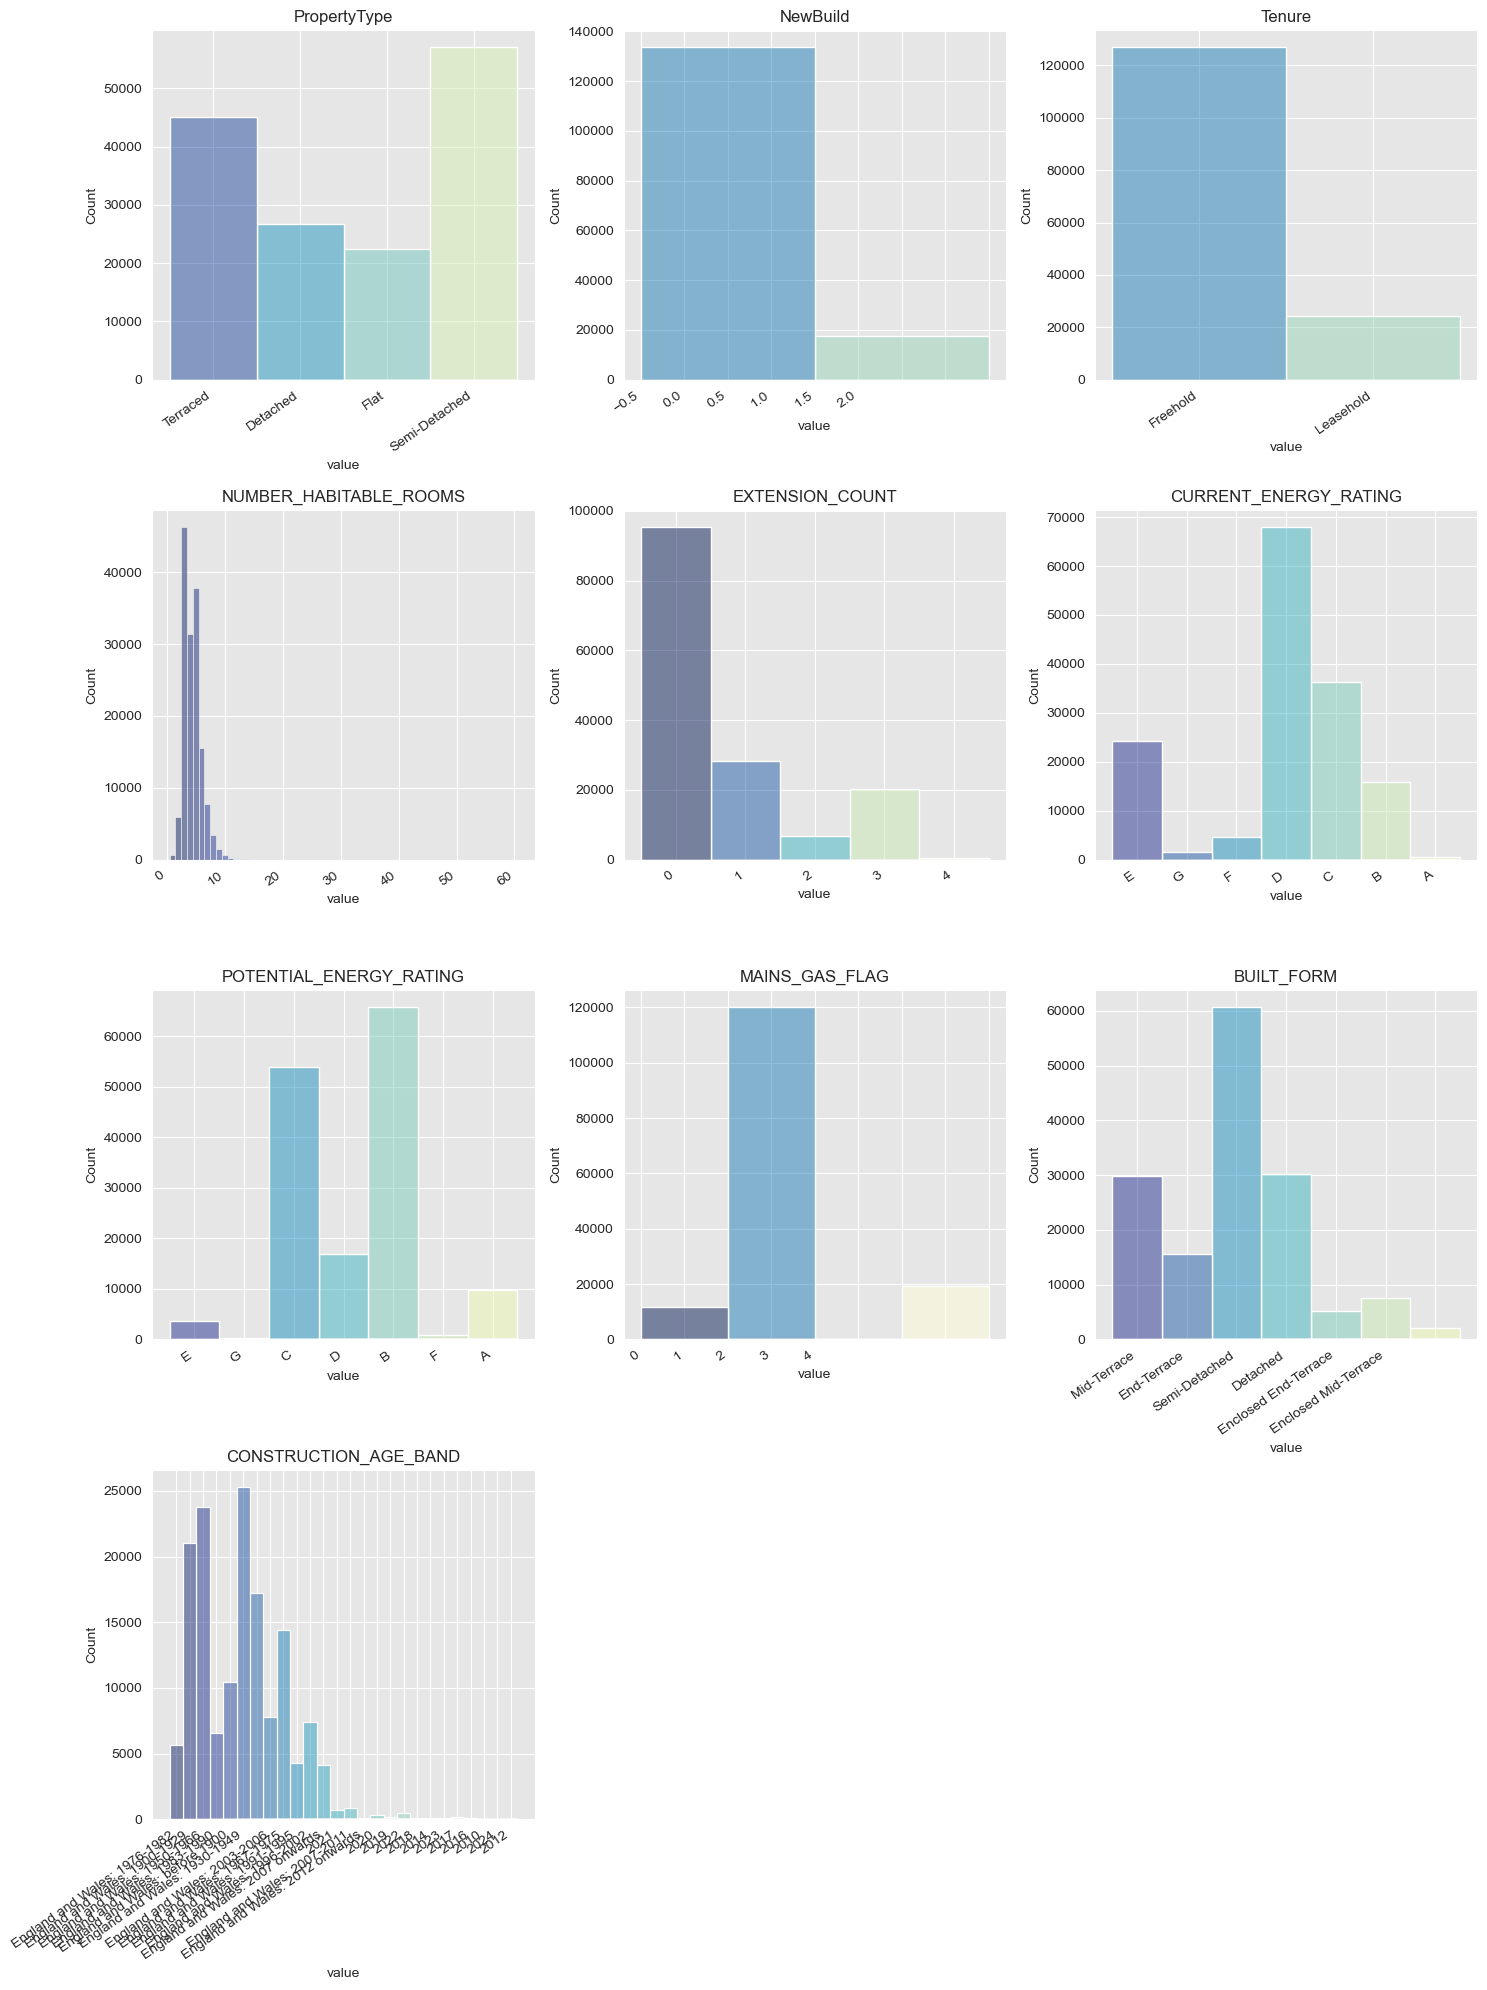

In [12]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

prop_dfL = pd.melt(prop_df, id_vars = "LRUniqueID", value_vars = prop_df.columns.difference(["LRUniqueID", "Latitude", "Longitude"]))
prop_dfL["value"] = prop_dfL["value"].replace({True: 1, False: 0, None: 3})

cols_toplot = ["PropertyType", "NewBuild", "Tenure", "NUMBER_HABITABLE_ROOMS", "EXTENSION_COUNT", "CURRENT_ENERGY_RATING",
               "POTENTIAL_ENERGY_RATING", "MAINS_GAS_FLAG", "BUILT_FORM", "CONSTRUCTION_AGE_BAND"]

#prop_dfL["value"] = prop_dfL["value"].fillna("Missing")

fig, ax = plt.subplots(4, 3, figsize = (15, 20))
ax = ax.ravel()

for idx, col in enumerate(cols_toplot):
    sns.histplot(prop_dfL[prop_dfL["variable"] == col], x = "value",
                 hue = "value", stat = "count", 
                 ax = ax[idx], legend = False,
                 discrete = True,
                 palette = "YlGnBu_r")
    ax[idx].set_title(col)
    #ax[idx].tick_params(axis='x', rotation=35)
    ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=35, ha="right")

for idx in range(len(cols_toplot), len(ax)):
    fig.delaxes(ax[idx])

fig.tight_layout()
plt.savefig(f"{figure_path}/prop_variableHIST.png", format = "PNG")
plt.show()